In [8]:
import time
import os.path
import os

#import helper_cityscapes as helper
#import helper_lyft as helper
import numpy as np

import warnings
import scipy.misc
import tensorflow as tf
from datetime import timedelta
from distutils.version import LooseVersion


import random

import skimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import PIL
from PIL import Image

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))


# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))





TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

## Set parameters

In [10]:
L2_REG = 1e-6
STDEV = 1e-3
KEEP_PROB = 0.5
LEARNING_RATE = 1e-4

EPOCHS = 1 #3 #1  #3 #50 #10 #30

BATCH_SIZE = 16 #8 #2 #16

# ?? why (600,800) leads to Incompatible shapes: [8,76,100,3] vs. [8,75,100,3]  ??
IMAGE_SHAPE = (256, 512) #(600, 800) #(256, 512)

NUM_CLASSES = 3

DATA_DIR = './data'
RUNS_DIR = './runs_lyft'
MODEL_DIR = './models_lyft/new'

log_dir = './log'
#model_path = "/tmp/model.ckpt"

In [11]:


train_dataset_dir = 'data/lyft_training_data/Train/CameraRGB/'
#train_dataset_dir = 'data/lyft_training_data/Test/CameraRGB/'

val_dataset_dir = 'data/lyft_training_data/Test/CameraRGB/'


gt_dataset_dir = 'data/lyft_training_data/Train/CameraSeg/'
#gt_dataset_dir = 'data/lyft_training_data/Test/CameraSeg/'

In [12]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

writer = skvideo.io.FFmpegWriter("lyft.mp4")
for x in os.listdir(train_dataset_dir):
    writer.writeFrame(scipy.misc.imread(os.path.join(train_dataset_dir, x)))
writer.close()

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_validation = train_test_split(os.listdir(train_dataset_dir),
                                                           os.listdir(gt_dataset_dir), test_size=0.20, random_state=0)

In [16]:

print("Training Set:   {} samples".format(len(X_train)))
print("validation set: {} samples".format(len(X_valid)))


Training Set:   71 samples
validation set: 18 samples


In [17]:
print(" type :" , type(X_valid))

 type : <class 'list'>


In [56]:
print(X_valid,y_validation )

['F62-52.png', 'F65-50.png', 'F70-45.png', 'F61-68.png', 'F66-67.png', 'F70-8.png', 'F65-80.png', 'F62-41.png', 'F68-75.png', 'F69-87.png', 'F61-94.png', 'F63-98.png', 'F69-13.png', 'F63-31.png', 'F61-97.png', 'F65-89.png', 'F69-22.png', 'F63-18.png', 'F66-78.png', 'F67-41.png', 'F68-1.png', 'F66-5.png', 'F66-70.png', 'F65-56.png', 'F69-94.png', 'F62-56.png', 'F69-83.png', 'F68-18.png', 'F64-13.png', 'F67-51.png', 'F69-42.png', 'F61-80.png', 'F69-46.png', 'F62-40.png', 'F69-58.png', 'F70-97.png', 'F64-23.png', 'F69-81.png', 'F62-67.png', 'F67-1.png', 'F64-7.png', 'F65-97.png', 'F70-75.png', 'F66-89.png', 'F70-93.png', 'F68-48.png', 'F63-76.png', 'F70-68.png', 'F61-58.png', 'F68-60.png', 'F64-70.png', 'F61-35.png', 'F68-56.png', 'F62-62.png', 'F63-23.png', 'F69-100.png', 'F65-8.png', 'F65-79.png', 'F67-66.png', 'F67-15.png', 'F67-4.png', 'F63-9.png', 'F70-31.png', 'F65-96.png', 'F66-84.png', 'F69-77.png', 'F70-38.png', 'F70-59.png', 'F67-50.png', 'F63-10.png', 'F61-57.png', 'F70-21.png'

In [57]:
random.shuffle(X_valid)

In [58]:
print(X_valid)

['F63-38.png', 'F64-60.png', 'F69-100.png', 'F69-22.png', 'F62-90.png', 'F67-55.png', 'F69-87.png', 'F68-99.png', 'F61-94.png', 'F61-26.png', 'F64-99.png', 'F64-27.png', 'F66-33.png', 'F61-82.png', 'F62-38.png', 'F68-60.png', 'F65-80.png', 'F64-23.png', 'F69-65.png', 'F70-72.png', 'F67-88.png', 'F66-76.png', 'F68-87.png', 'F65-39.png', 'F70-9.png', 'F61-5.png', 'F63-76.png', 'F70-45.png', 'F64-9.png', 'F69-80.png', 'F63-48.png', 'F61-48.png', 'F66-55.png', 'F61-29.png', 'F64-30.png', 'F68-1.png', 'F64-11.png', 'F65-9.png', 'F63-10.png', 'F69-81.png', 'F69-47.png', 'F70-37.png', 'F68-75.png', 'F70-59.png', 'F61-35.png', 'F61-50.png', 'F68-64.png', 'F70-68.png', 'F61-58.png', 'F68-26.png', 'F68-59.png', 'F66-78.png', 'F66-69.png', 'F65-79.png', 'F67-76.png', 'F67-9.png', 'F66-60.png', 'F68-89.png', 'F61-37.png', 'F65-83.png', 'F68-90.png', 'F64-13.png', 'F63-98.png', 'F67-15.png', 'F67-71.png', 'F69-16.png', 'F69-46.png', 'F67-94.png', 'F65-96.png', 'F70-77.png', 'F64-51.png', 'F62-61.pn

In [59]:
print(y_validation)

['F62-52.png', 'F65-50.png', 'F70-45.png', 'F61-68.png', 'F66-67.png', 'F70-8.png', 'F65-80.png', 'F62-41.png', 'F68-75.png', 'F69-87.png', 'F61-94.png', 'F63-98.png', 'F69-13.png', 'F63-31.png', 'F61-97.png', 'F65-89.png', 'F69-22.png', 'F63-18.png', 'F66-78.png', 'F67-41.png', 'F68-1.png', 'F66-5.png', 'F66-70.png', 'F65-56.png', 'F69-94.png', 'F62-56.png', 'F69-83.png', 'F68-18.png', 'F64-13.png', 'F67-51.png', 'F69-42.png', 'F61-80.png', 'F69-46.png', 'F62-40.png', 'F69-58.png', 'F70-97.png', 'F64-23.png', 'F69-81.png', 'F62-67.png', 'F67-1.png', 'F64-7.png', 'F65-97.png', 'F70-75.png', 'F66-89.png', 'F70-93.png', 'F68-48.png', 'F63-76.png', 'F70-68.png', 'F61-58.png', 'F68-60.png', 'F64-70.png', 'F61-35.png', 'F68-56.png', 'F62-62.png', 'F63-23.png', 'F69-100.png', 'F65-8.png', 'F65-79.png', 'F67-66.png', 'F67-15.png', 'F67-4.png', 'F63-9.png', 'F70-31.png', 'F65-96.png', 'F66-84.png', 'F69-77.png', 'F70-38.png', 'F70-59.png', 'F67-50.png', 'F63-10.png', 'F61-57.png', 'F70-21.png'

In [60]:
print(X_valid[0])
print(y_validation[0])

F63-38.png
F62-52.png


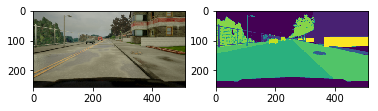

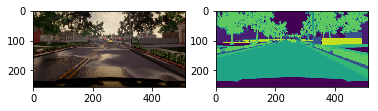

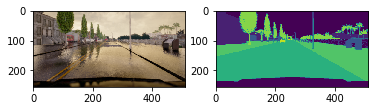

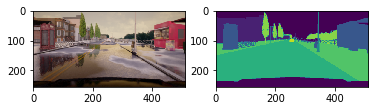

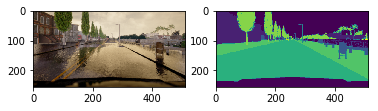

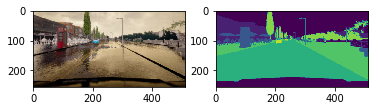

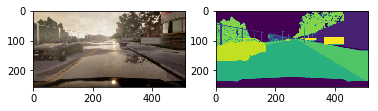

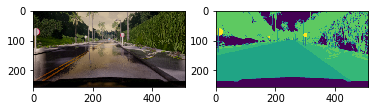

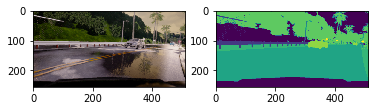

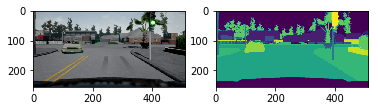

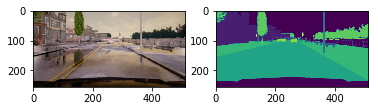

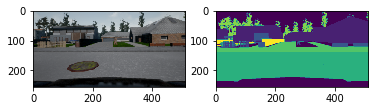

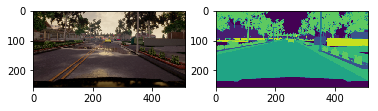

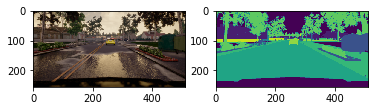

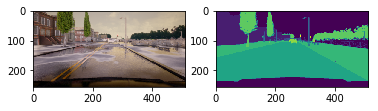

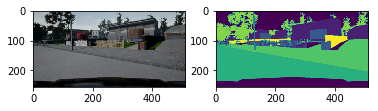

In [63]:
for image_file in X_valid[32:32+16]:
    gt_image_orig = scipy.misc.imread(os.path.join(gt_dataset_dir, image_file))
    gt_image_process = preprocess_labels(gt_image_orig)
                
                #(600,800,3) crop to (400,800,3) resize to (256,512,3)
    label_image_new = scipy.misc.imresize( gt_image_process[150:550,:,:] , IMAGE_SHAPE) 
                
                #print("label_image_new.shape: ", label_image_new.shape)
                #image = cv2.imread(os.path.join(train_dataset_dir, image_file[:-5]+'.png'))
                
                
                #image = scipy.misc.imread(os.path.join(train_dataset_dir, image_file))
                
    image = scipy.misc.imresize(scipy.misc.imread(os.path.join(train_dataset_dir, image_file))[150:550,:,:],
                                            IMAGE_SHAPE)
    
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,:])
    
    plt.subplot(1,2,2)
    plt.imshow(label_image_new[:,:,0])
    
    i = i + 1 
    plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


img shape (600, 800, 3)
gt_img shape (600, 800, 3)
img shape (600, 800, 3)
gt_img shape (600, 800, 3)


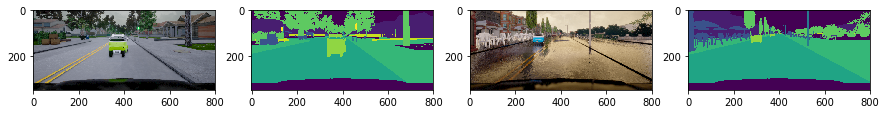

img shape (600, 800, 3)
gt_img shape (600, 800, 3)
img shape (600, 800, 3)
gt_img shape (600, 800, 3)


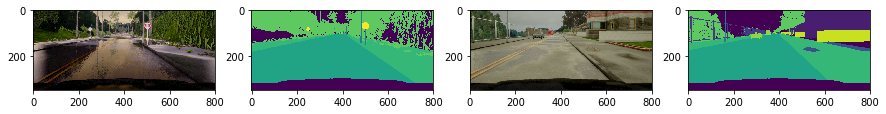

img shape (600, 800, 3)
gt_img shape (600, 800, 3)
img shape (600, 800, 3)
gt_img shape (600, 800, 3)


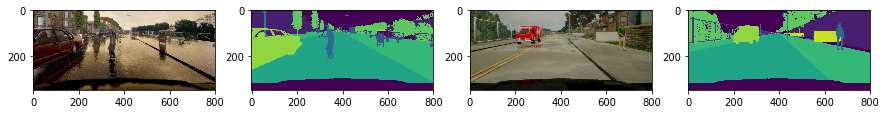

img shape (600, 800, 3)
gt_img shape (600, 800, 3)
img shape (600, 800, 3)
gt_img shape (600, 800, 3)


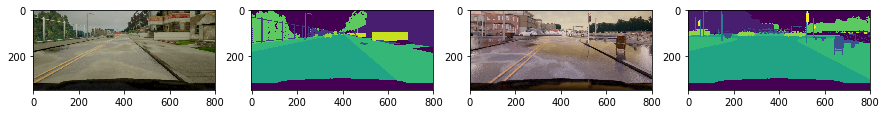

img shape (600, 800, 3)
gt_img shape (600, 800, 3)
img shape (600, 800, 3)
gt_img shape (600, 800, 3)


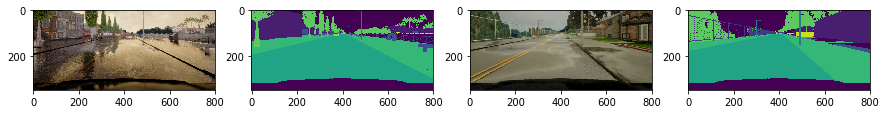

In [11]:
import random
for i in range(5):
    index1 = random.randint(0, len(X_train))
    
    index2 = random.randint(0, len(X_valid))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index1]))
    print("img shape", img.shape)
    plt.subplot(1,4,1)
    plt.imshow(img[200:550,:,:])
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index1]))
    print("gt_img shape", gt_img.shape)
    label_image_new = preprocess_labels(gt_img)
    plt.subplot(1,4,2)
    plt.imshow(label_image_new[200:550,:,0])
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_valid[index2]))
    print("img shape", img.shape)
    plt.subplot(1,4,3)
    plt.imshow(img[200:550,:,:])
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_validation[index2]))
    print("gt_img shape", gt_img.shape)
    label_image_new = preprocess_labels(gt_img)
    plt.subplot(1,4,4)
    plt.imshow(label_image_new[200:550,:,0])
    
    i = i + 1 
    plt.show()

In [12]:
#print(y_train)

In [ ]:
def showim(img):
    img_prep = np.concatenate((img, img, img), axis =2)
    plt.figure()
    plt.imshow(img_prep, cmap='gray')
    plt.show()

def showimg(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [ ]:
def crop(img):
   

    return img[100:500, :, :]

In [ ]:
import random
for i in range(5):
    index = random.randint(0, len(X_train))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index]))
    print("img shape", img.shape)
    plt.subplot(1,4,1)
    plt.imshow(crop(img))
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index]))
    print("gt_img shape", gt_img.shape)
    plt.subplot(1,4,2)
    plt.imshow(gt_img[100:500,:,0])
    
    plt.subplot(1,4,3)
    label_image_new = preprocess_labels(gt_img)
    plt.imshow(label_image_new[100:500,:,0])

    plt.subplot(1,4,4)
    plt.imshow(img)
    
    i = i + 1 
    plt.show()
    
    
    
    

    road_func = lambda img: img[:,:,0]==7
    
    road_img = road_func(scipy.misc.imresize(label_image_new[100:500,:,:], IMAGE_SHAPE))
    
    road_img_1 = road_img.reshape(*road_img.shape, 1)
    road_img_int = road_img_1.astype(np.uint8)*255
    showim(road_img_int)
    
    car_func = lambda img: img[:,:,0]== 10
    car_img = car_func(scipy.misc.imresize(label_image_new[100:500,:,], IMAGE_SHAPE))
    #car_img = car_func(label_image_new)
    
    car_img_1 = car_img.reshape(*car_img.shape, 1)
    car_img_int = car_img_1.astype(np.uint8)*255
    showim(car_img_int)
    
    gt_obj = np.concatenate((road_img_1, car_img_1), axis=2)
    
    gt_bg = np.all(gt_obj == 0, axis=2)
    
    gt_bg_1 = gt_bg.reshape(gt_bg.shape[0], gt_bg.shape[1], 1)
    gt_bg_int = gt_bg_1.astype(np.uint8)*255
    showim(gt_bg_int)

In [ ]:
def flip(img):
    # NumPy.'img' = A single image.
    return  np.fliplr(img)

    

In [ ]:
for i in range(5):
    index = random.randint(0, len(X_train))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index]))
    #img = (os.path.join(train_dataset_dir, X_train[index]))
    
    print("img shape", img.shape)
    
    flip_1 = flip( img)
    
    plt.subplot(1,4,1)
    plt.imshow(flip_1)
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index]))
    #gt_img = (os.path.join(gt_dataset_dir, y_train[index]))
    print("gt_img shape", gt_img.shape)
    
    gt_1 = flip(gt_img)
    
    plt.subplot(1,4,2)
    plt.imshow(gt_1[100:500,:,0])
    
    plt.subplot(1,4,3)
    label_image_new = preprocess_labels(gt_1)
    plt.imshow(  label_image_new[100:500,:,0])

    plt.subplot(1,4,4)
    plt.imshow(img)
    
    i = i + 1 
    plt.show()
    
    
    
    

    road_func = lambda img: img[:,:,0]==7
    
    road_img = road_func(scipy.misc.imresize(label_image_new[100:500,:,:], IMAGE_SHAPE))
    
    road_img_1 = road_img.reshape(*road_img.shape, 1)
    road_img_int = road_img_1.astype(np.uint8)*255
    showim(road_img_int)
    
    car_func = lambda img: img[:,:,0]== 10
    car_img = car_func(scipy.misc.imresize(label_image_new[100:500,:,], IMAGE_SHAPE))
    #car_img = car_func(label_image_new)
    
    car_img_1 = car_img.reshape(*car_img.shape, 1)
    car_img_int = car_img_1.astype(np.uint8)*255
    showim(car_img_int)
    
    gt_obj = np.concatenate((road_img_1, car_img_1), axis=2)
    
    gt_bg = np.all(gt_obj == 0, axis=2)
    
    gt_bg_1 = gt_bg.reshape(gt_bg.shape[0], gt_bg.shape[1], 1)
    gt_bg_int = gt_bg_1.astype(np.uint8)*255
    showim(gt_bg_int)

In [ ]:
def zoom(img):
    scale_out = skimage.transform.rescale(img, scale=2.0, mode='constant')
    
    scale_in = skimage.transform.rescale(img, scale=0.5, mode='constant')
    
    return scale_out, scale_in

In [ ]:
for i in range(5):
    index = random.randint(0, len(X_train))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index]))
    #img = (os.path.join(train_dataset_dir, X_train[index]))
    
    print("img shape", img.shape)
    
    img_out, img_in = zoom(img)
    
    plt.subplot(1,4,1)
    plt.imshow(img_out)
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index]))
    #gt_img = (os.path.join(gt_dataset_dir, y_train[index]))
    print("gt_img shape", gt_img.shape)
    
    gt_1 = flip(gt_img)
    
    plt.subplot(1,4,2)
    #plt.imshow(gt_1[250:550,:,0])
    plt.imshow(img_in)
    
    
    plt.subplot(1,4,3)
    label_image_new = preprocess_labels(gt_1)
    plt.imshow(  label_image_new[250:550,:,0])

    plt.subplot(1,4,4)
    plt.imshow(bc_img(img, contr, bright))
    
    i = i + 1 
    plt.show()

In [ ]:
def bc_img(img, s = 1.0, m = 0.0):
    img = img.astype(np.int)
    img = img * s + m
    img[img > 255] = 255
    img[img < 0] = 0
    img = img.astype(np.uint8)
    return img 

In [ ]:
contr = random.uniform(0.85, 1.15) # Contrast augmentation
bright = random.randint(-40, 30) # Brightness augmentation
                
               

In [ ]:
for i in range(5):
    index = random.randint(0, len(X_train))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index]))
    #img = (os.path.join(train_dataset_dir, X_train[index]))
    
    print("img shape", img.shape)
    
    
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index]))
    #gt_img = (os.path.join(gt_dataset_dir, y_train[index]))
    print("gt_img shape", gt_img.shape)
    
    gt_1 = flip(gt_img)
    
    plt.subplot(1,4,2)
    plt.imshow(gt_1[250:550,:,0])
    
    plt.subplot(1,4,3)
    label_image_new = preprocess_labels(gt_1)
    plt.imshow(  label_image_new[250:550,:,0])

    plt.subplot(1,4,4)
    plt.imshow(bc_img(img, contr, bright))
    
    i = i + 1 
    plt.show()

In [ ]:
def random_crop(img, gt  ):
    h,w = img.shape[0], img.shape[1]
    #nw = random.randint(768, w-2) # Random crop size
    nw = random.randint(200,400) # Random crop size
    #nh = int(nw / 2) # Keep original aspect ration
    nh = int(nw / 8.0 * 3.0)
    x1 = random.randint(0, w - nw) # Random position of crop
    y1 = random.randint(0, h - nh)
    
    cropimg = img[y1:(y1+nh), x1:(x1+nw), :]
    cropgt= gt[y1:(y1+nh), x1:(x1+nw), :]
    return cropimg, gt 

"""
random crop on (350,800) and reshape to (256, 512 ) for train ? 

"""

In [ ]:
for i in range(5):
    index = random.randint(0, len(X_train))
    
    plt.figure(1, figsize=(15,15))
    
    img = scipy.misc.imread(os.path.join(train_dataset_dir, X_train[index]))
    #img = (os.path.join(train_dataset_dir, X_train[index]))
    
    print("img shape", img.shape)
    
    
    
    plt.subplot(1,6,1)
    plt.imshow(img)
    
    gt_img = scipy.misc.imread(os.path.join(gt_dataset_dir, y_train[index]))
    #gt_img = (os.path.join(gt_dataset_dir, y_train[index]))
    print("gt_img shape", gt_img.shape)
    
    gt_1 = flip(gt_img)
    
    plt.subplot(1,6,2)
    plt.imshow(gt_1[250:550,:,0])
    
    
    
    plt.subplot(1,6,3)
    label_image_new = preprocess_labels(gt_1)
    plt.imshow(  label_image_new[250:550,:,0])

    crop_img = img[250:550,:,:] #scipy.misc.toimage(img[250:550,:,:])
    gt = label_image_new[250:550,:,:] #scipy.misc.toimage(label_image_new[250:550,:,0])
    #crop_img_1, crop_gt = random_crop(crop_img, gt[:,:,0])
    crop_img_1, crop_gt = random_crop(crop_img, gt)
    
    crop = scipy.misc.toimage(crop_img_1)
   
    
    cropgt = scipy.misc.toimage(crop_gt)
    plt.subplot(1,6,4)
    plt.imshow( crop)
    
    crop = resize(crop_img_1, (256, 512))
    plt.subplot(1,6,5)
    #image = Image.open(crop)
    #plt.imshow( crop.resize(256,512), PIL.Image.ANTIALIAS )
    plt.imshow( crop)
    
    cropgt = rescale(crop_gt, 1.0 / 4.0)
    plt.subplot(1,6,6)
    plt.imshow( cropgt[:,:,0])
    
    i = i + 1 
    plt.show()

In [ ]:
# Make folder for current run
process_dir = os.path.join('data/lyft_training_data/Train', str(time.time()))

if os.path.exists(process_dir):
    shutil.rmtree(process_dir)
os.makedirs(process_dir)

# Run NN on test images and save them to HD
print('start preprocess. Saving processed train images to: {}'.format(process_dir))

'''
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape, num_classes)
    
    
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(process_dir, name), image)
'''


In [18]:
def preprocess_labels(label_image):
    # Identify lane marking pixels (label is 6)
    #print("label_image[:,:,0] = ", label_image[:,:,0])
    
    lane_marking_pixels = (label_image[:,:,0] == 6).nonzero()
    #print("lane_marking_pixels = ", lane_marking_pixels)
    #print("lane_marking_pixels shape", lane_marking_pixels.shape)
    
    # Set lane marking pixels to road (label is 7)
    labels_new = label_image.copy()
    labels_new[lane_marking_pixels] = 7

    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new

In [19]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    graph = tf.get_default_graph()
    
    writer = tf.summary.FileWriter(log_dir, sess.graph)
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    return input, keep_prob, layer3, layer4, layer7

print("Load VGG Model:")
#tests.test_load_vgg(load_vgg, tf)

Load VGG Model:


In [20]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    layer7_conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.layers.conv2d_transpose(layer7_conv_1x1, num_classes, 4, 2,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    layer4_conv_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.add(output, layer4_conv_1x1)
    output = tf.layers.conv2d_transpose(output, num_classes, 4, 2,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    layer3_conv_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.add(output, layer3_conv_1x1)
    output = tf.layers.conv2d_transpose(output, num_classes, 16, 8,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))   
    return output



In [21]:
# Loss with weights
weights = [0.3, 0.6, 0.3]

# Classes are unbalanced, that is why we can add some weight to the road class.
# From https://github.com/MarvinTeichmann/KittiSeg
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    print(" ---------------- optimize -------------------------------- ")
    
    #print("nn_last_layer shape : " , nn_last_layer.shape) # (?, ?, ?, 3) ?? 
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name = 'logits')  # (?, num_classes=3)
    #print("logits shape : ", logits.shape)
    #print("logits shape : ", np.shape(logits))
    #tf.Print(logits, [tf.shape(logits)])
    
    #print("correct_label shape : " , correct_label.shape) #(?, ?, ?, ?, 3)
    labels = tf.reshape(correct_label, (-1, num_classes), name = 'labels')
    #print("labels shape : ", labels.shape)   #  (?, num_classes = 3)
    #print("labels shape : ", np.shape(labels)) 
    #tf.Print(labels, [tf.shape(labels)])
    
    softmax = tf.nn.softmax(logits,name='softmax')
    #tf.Print(softmax, [tf.shape(softmax)])
    
    cross_entropy = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax), weights), reduction_indices=[1])
    cross_entropy_loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    #print("cross_entropy_loss : " , cross_entropy_loss)
    
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    #train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy_loss)
    
    
    # for tensorboard scalar
    tf.summary.scalar('loss', cross_entropy_loss)
    
    acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(labels, 1), 
                                       predictions=tf.argmax(logits,1),name='acc_op')
    
    tf.summary.scalar('accuracy', acc)
    
    return logits, train_op, cross_entropy_loss, acc_op

print("Optimize Test:")
#tests.test_optimize(optimize)

Optimize Test:


In [22]:


"""  howto evaludate accuracy on pixels ??


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    
"""


'  howto evaludate accuracy on pixels ??\n\n\ndef evaluate(X_data, y_data):\n    num_examples = len(X_data)\n    total_accuracy = 0\n    sess = tf.get_default_session()\n    for offset in range(0, num_examples, BATCH_SIZE):\n        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]\n        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})\n        total_accuracy += (accuracy * len(batch_x))\n    return total_accuracy / num_examples\n    \n'

In [23]:
#x = tf.placeholder(tf.float32, (None, 32, 32, 1))
#y = tf.placeholder(tf.int32, (None))
#one_hot_y = tf.one_hot(y, 43)

In [24]:
def gen_batch_function(set_x, set_y, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        num_examples = len(set_x)
        
        #image_paths = os.listdir(gt_data_folder)
        
        #set_x, set_y = random.shuffle(set_x, set_y)
        
        for batch_i in range(0, num_examples, batch_size):
            print("-----------------batch_i = " + str(batch_i) + " , batch_size = " + str(batch_size) + " --------------------------")
            images = []
            gt_images = []
            
            end = min(batch_i + batch_size, num_examples)
            
            batch_x, batch_y = set_x[batch_i:end], set_y[batch_i:end]
            
            for image_file in set_x[batch_i:batch_i+batch_size]:
                
                gt_image_orig = scipy.misc.imread(os.path.join(gt_dataset_dir, image_file))
                gt_image_process = preprocess_labels(gt_image_orig)
                
                #(600,800,3) crop to (400,800,3) resize to (256,512,3)
                label_image_new = scipy.misc.imresize( gt_image_process[150:550,:,:] , image_shape) 
                
                #print("label_image_new.shape: ", label_image_new.shape)
                #image = cv2.imread(os.path.join(train_dataset_dir, image_file[:-5]+'.png'))
                
                
                #image = scipy.misc.imread(os.path.join(train_dataset_dir, image_file))
                
                image = scipy.misc.imresize(scipy.misc.imread(os.path.join(train_dataset_dir, image_file))[150:550,:,:],
                                            image_shape)
                
                #print("image.shape: " , image.shape)
                
                '''
                image, gt_image = random_crop(image, gt_image) #Random crop augmentation

                contr = random.uniform(0.85, 1.15) # Contrast augmentation
                bright = random.randint(-40, 30) # Brightness augmentation
                
                image = bc_img(image, contr, bright)
                '''
                


                road_func = lambda img: img[:,:,0]==7
                road_img = road_func(label_image_new)

                
                road_img_1 = road_img.reshape(*road_img.shape, 1)
                road_img_int = road_img_1.astype(np.uint8)*255
                #showim(road_img_int)

                car_func = lambda img: img[:,:,0]== 10
                car_img = car_func(label_image_new)

                
                car_img_1 = car_img.reshape(*car_img.shape, 1)
                car_img_int = car_img_1.astype(np.uint8)*255
                #showim(car_img_int)
    
                gt_obj = np.concatenate((road_img_1, car_img_1), axis=2)
                
                
                gt_bg = np.all(gt_obj == 0, axis=2)
                gt_bg_1 = gt_bg.reshape(gt_bg.shape[0], gt_bg.shape[1], 1)
                gt_bg_int = gt_bg_1.astype(np.uint8)*255
                #showim(gt_bg_int)
                
                
                gt_image = np.concatenate((gt_obj, gt_bg_1), axis=2)

                
                images.append(image)
                gt_images.append(gt_image)
            yield np.array(images), np.array(gt_images), len(images)
    return get_batches_fn

In [25]:
summaries_dir = './summaries'

#def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
#             correct_label, keep_prob, learning_rate, saver, data_dir, logits):
def train_nn(sess, epochs, batch_size, train_op, cross_entropy_loss, acc_op, input_image,
             correct_label, keep_prob, learning_rate, saver, data_dir, logits):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function

    if summaries_dir is not None:
        summary_writer = tf.summary.FileWriter(summaries_dir, graph=sess.graph)
    
    train = []
    val = []
            
    
    for epoch in range(epochs):
        print("----------------- train : epoch of " + str(epoch) + " --------------------------")
        
        #if validation_accuracy > 0.95:
        #    break
            
        epoch_train_accuracy = 0.0
        
        s_time = time.time()
        
        random.shuffle(X_train)
        get_batches_fn_train =  gen_batch_function( X_train, y_train, IMAGE_SHAPE)
        
        random.shuffle(X_valid)
        get_batches_fn_val =  gen_batch_function( X_valid, y_validation, IMAGE_SHAPE)
        
        for image, targets, len_batch in get_batches_fn_train(batch_size):
            _, loss, train_acc = sess.run([train_op, cross_entropy_loss, acc_op], feed_dict = {input_image: image, 
                                                                            correct_label: targets, 
                                                                            keep_prob: KEEP_PROB, 
                                                                            learning_rate: LEARNING_RATE }) #/ (epoch/100 + 1)
            print("train loss:", loss)
            print("train acc:", train_acc)
            epoch_train_accuracy += (train_acc * len_batch)
            

        epoch_train_accuracy = epoch_train_accuracy / len(X_train)
        #print(" type epoch_train_accuracy:", type(epoch_train_accuracy))
        #train_acc[epoch] = epoch_train_accuracy
        train.append(epoch_train_accuracy)
        #epoch_train_accuracy = epoch_train_accuracy.astype(np.float32)
        #acc = epoch_train_accuracy.astype(np.uint8)
        
        #print(" type train_acc:", type(acc))
        #train_acc.append(acc)
        #print(train_acc)
        
        epoch_val_accuracy = 0.0
        for image, targets, len_batch in get_batches_fn_val(batch_size):
            val_loss, val_acc = sess.run([cross_entropy_loss, acc_op], feed_dict = {input_image: image, 
                                                                                    correct_label: targets,
                                                                                    keep_prob: 1.0})
            print("val loss:", val_loss)
            print("val acc:", val_acc)
            epoch_val_accuracy += (val_acc * len_batch)
        
        epoch_val_accuracy = epoch_val_accuracy / len(X_valid)
        #print(" type epoch_val_accuracy:", type(epoch_val_accuracy))
        #epoch_val_accuracy = epoch_val_accuracy.astype(np.float32)
        
        #acc = epoch_val_accuracy.astype(np.uint8)
        #print(" type val_acc:", type(acc))
        
        #val_acc[epoch] = epoch_val_accuracy
        #val_acc.append(acc)
        #print(val_acc)
        
        val.append(epoch_val_accuracy)
        
        ########################## 1 epoch ends
        
        # Print data on the learning process
        print("Epoch: {}".format(epoch + 1), "/ {}".format(epochs), " Loss: {:.3f}".format(loss), " Time: ",
              str(timedelta(seconds=(time.time() - s_time))))
        
        print("train Accuracy = {:.3f}".format(epoch_train_accuracy))
        print("Validation Accuracy = {:.3f}".format(epoch_val_accuracy))
        
        output_dir = data_dir
        if (epoch + 1) % 5 == 0: # Save into different sub-folder every 5 epochs
        #if (epoch ) % 5 == 0: 
            output_dir = os.path.join(data_dir, str('cont_epoch_' + str(epoch)))
            if os.path.exists(output_dir):
                shutil.rmtree(output_dir)
            os.makedirs(output_dir)
        
            print("-----------------save ckpt after every epoch --------------------------")
            save_path = saver.save(sess, os.path.join(output_dir, 'cont_epoch_' + str(epoch) + '.ckpt'))
        
        # draw every 1 epoch ?
        fig = plt.figure()
        plt.plot(np.array(train))
        plt.plot(np.array(val))
        plt.title(' epoch acc ')
        plt.ylabel(' acc ')
        plt.xlabel('epoch')
        plt.legend(['training set', 'validation set'], loc='upper left')
        plt.show()
        fig.savefig(os.path.join(output_dir, 'epoch_' + str(epoch)+'.png'))
        plt.close(fig)
        
    # loop of epochs ends
    train_acc_array = np.array(train)
    val_acc_array = np.array(val)
    print("train_acc_array :", train_acc_array)
    print("val_acc_array :", val_acc_array)
    
    return train_acc_array, val_acc_array

#Don't use the provided test, as we have a different input to the function
#tests.test_train_nn(train_nn)

In [26]:
from moviepy.editor import VideoFileClip

In [27]:
def run():
    #tests.test_for_kitti_dataset(DATA_DIR)
    # Download pretrained vgg model
    #helper.maybe_download_pretrained_vgg(DATA_DIR)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    print("Start training...")
    
    
    
    # ========== issue here !!
    config = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
    
    with tf.Session(config=config) as sess:
    #with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(DATA_DIR, 'vgg')
        
        
        # Create function to get batches
        #get_batches_fn = helper.gen_batch_function(os.path.join(DATA_DIR, 'leftImg8bit'), IMAGE_SHAPE)
        
        #get_batches_fn = gen_batch_function(train_dataset_dir, gt_dataset_dir, IMAGE_SHAPE)
        #get_batches_fn = gen_batch_function(X_train, y_train, IMAGE_SHAPE)
        
    
        #get_batches_fn = lyft_gen_batch_function(train_dataset_dir, gt_dataset_dir, IMAGE_SHAPE)
        
        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
        # Add some augmentations, see helper.py
        input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        output = layers(layer3, layer4, layer7, NUM_CLASSES)
        
        #model = layers()
        #model.summary()

        correct_label = tf.placeholder(dtype = tf.float32, shape = (None, None, None, NUM_CLASSES))
        #correct_label = tf.placeholder(dtype = tf.float32, shape = (None, None, None,None, NUM_CLASSES))
        
        learning_rate = tf.placeholder(dtype = tf.float32)
        logits, train_op, cross_entropy_loss,train_accuracy = optimize(output, correct_label, learning_rate, NUM_CLASSES)
        
        


        
        # logits shape: tf.float32 (None, None, None, NUM_CLASSES)
        
        
        # Create some variables.
        w1=tf.Variable(tf.random_normal(shape=[2]),name='w1')
        #print(sess.run(w1))
        
        
        tf.set_random_seed(123)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        print(sess.run(w1))
        

        saver = tf.train.Saver() #Simple model saver
        #saver.save(sess, 'lyft')
            # Save model weights to disk

        #save_path = saver.save(sess, model_path)
        #print("Model saved in file: %s" % save_path)
    
        #train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss, input, correct_label,
        #         keep_prob, learning_rate,  saver, MODEL_DIR, logits)
        #train_nn(sess, EPOCHS, BATCH_SIZE, train_op, cross_entropy_loss, input, correct_label,
        #         keep_prob, learning_rate,  saver, MODEL_DIR, logits)
        
        train_acc_array, val_acc_array = train_nn(sess, EPOCHS, BATCH_SIZE, train_op, cross_entropy_loss,train_accuracy, 
                                                  input, correct_label,keep_prob, learning_rate,  saver, MODEL_DIR, logits)
        
        #model.save('./model/my_model.h5')

        ### plot the training and validation loss for each epoch
        #plt.plot(train_acc_array)
        #plt.plot(val_acc_array)
        #plt.title(' epoch acc ')
        #plt.ylabel(' acc ')
        #plt.xlabel('epoch')
        #plt.legend(['training set', 'validation set'], loc='upper right')
        #plt.show()
            
        # Save inference data using helper.save_inference_samples
        #helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, input, NUM_CLASSES)
        
        # ============================================================================
        # OPTIONAL: Apply the trained model to a video
        '''
        clip1 = VideoFileClip("unterhaching.mp4")
        lambda_for_func = lambda imgg: helper.single_img_inference(imgg, IMAGE_SHAPE, sess, input, logits, keep_prob)
        out_clip = clip1.fl_image(lambda_for_func)
        
        output = 'output-50-epoch.mp4'
        out_clip.write_videofile(output, audio=False)
        '''


Start training...
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Instructions for updating:
Use the retry module or similar alternatives.
 ---------------- optimize -------------------------------- 
[ 0.84550965 -0.6892706 ]
----------------- train : epoch of 0 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.33724
train acc: 0.33353662
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.3369358
train acc: 0.35137534
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.3282201
train acc: 0.39019904
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.32122508
train acc: 0.43082428
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.30509967
train acc: 0.44808754
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.28

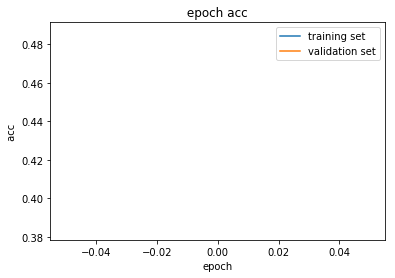

----------------- train : epoch of 1 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.2876143
train acc: 0.51303935
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.27752417
train acc: 0.53130513
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.2838612
train acc: 0.54649365
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.23994762
train acc: 0.5599359
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.2468753
train acc: 0.56483966
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.24374108
val acc: 0.5748603
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.2337167
val acc: 0.5763348
Epoch: 2 / 30  Loss: 0.247  Time:  0:00:16.583814
train Accuracy = 0.540
Validation Accuracy = 0.575


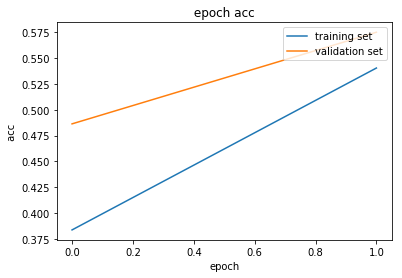

----------------- train : epoch of 2 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.2535319
train acc: 0.58317906
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.23829271
train acc: 0.5899215
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.23549895
train acc: 0.5952292
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.23502782
train acc: 0.60078037
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.2267144
train acc: 0.6031414
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.22657788
val acc: 0.6076537
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.18370913
val acc: 0.6082354
Epoch: 3 / 30  Loss: 0.227  Time:  0:00:16.579775
train Accuracy = 0.593
Validation Accuracy = 0.608


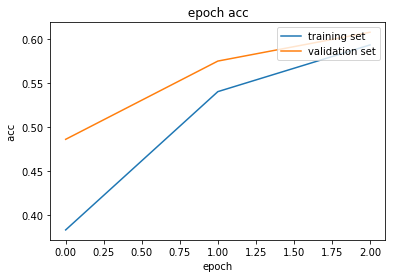

----------------- train : epoch of 3 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.24060194
train acc: 0.6118095
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.22718796
train acc: 0.6149133
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.1979859
train acc: 0.61813074
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.2190702
train acc: 0.62030536
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.18144298
train acc: 0.62145096
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.19165458
val acc: 0.6241247
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.20016357
val acc: 0.62441057
Epoch: 4 / 30  Loss: 0.181  Time:  0:00:16.568169
train Accuracy = 0.617
Validation Accuracy = 0.624


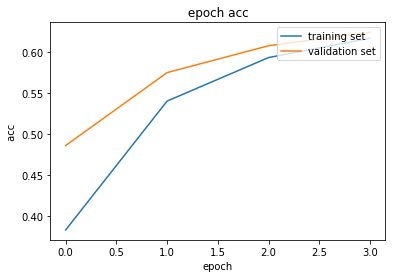

----------------- train : epoch of 4 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.16959432
train acc: 0.62673795
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.19839051
train acc: 0.6284578
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.20221528
train acc: 0.630183
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.21340679
train acc: 0.6322482
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.20205823
train acc: 0.6329594
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.17938876
val acc: 0.6359614
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.21576658
val acc: 0.63622737
Epoch: 5 / 30  Loss: 0.202  Time:  0:00:16.576114
train Accuracy = 0.630
Validation Accuracy = 0.636
-----------

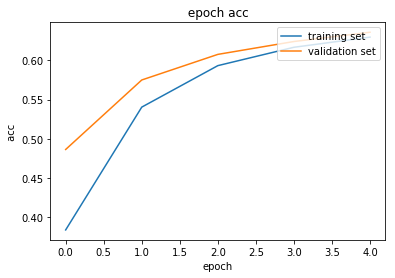

----------------- train : epoch of 5 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.20413974
train acc: 0.63818324
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.18408918
train acc: 0.6405779
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.17775822
train acc: 0.6428651
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.16791324
train acc: 0.6446431
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.18046339
train acc: 0.6455093
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.1604262
val acc: 0.64919597
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.18874213
val acc: 0.6496124
Epoch: 6 / 30  Loss: 0.180  Time:  0:00:16.706822
train Accuracy = 0.642
Validation Accuracy = 0.649


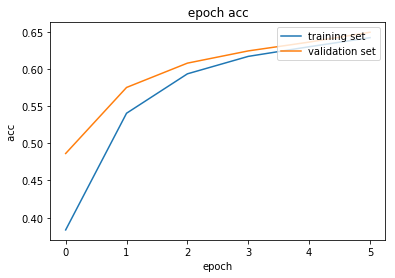

----------------- train : epoch of 6 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.17295031
train acc: 0.6529112
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.17249884
train acc: 0.6570692
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.16733827
train acc: 0.66145265
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.16333804
train acc: 0.66560155
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.13365243
train acc: 0.66755235
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.13975728
val acc: 0.67173535
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.16877127
val acc: 0.67217314
Epoch: 7 / 30  Loss: 0.134  Time:  0:00:16.717400
train Accuracy = 0.660
Validation Accuracy = 0.672


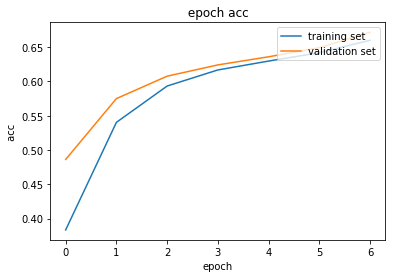

----------------- train : epoch of 7 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.14688914
train acc: 0.6760652
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.13382477
train acc: 0.68096095
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.13821933
train acc: 0.68568295
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.1291207
train acc: 0.6902281
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.20610139
train acc: 0.69171363
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.1195984
val acc: 0.6961359
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.09445876
val acc: 0.6967863
Epoch: 8 / 30  Loss: 0.206  Time:  0:00:16.697459
train Accuracy = 0.684
Validation Accuracy = 0.696


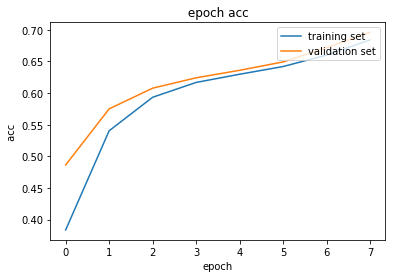

----------------- train : epoch of 8 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.12320612
train acc: 0.70118153
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.1345047
train acc: 0.7046066
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.11554904
train acc: 0.70859134
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.11384709
train acc: 0.7123664
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.11148434
train acc: 0.7140007
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.09827895
val acc: 0.71782815
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.08602007
val acc: 0.7183376
Epoch: 9 / 30  Loss: 0.111  Time:  0:00:16.802580
train Accuracy = 0.707
Validation Accuracy = 0.718


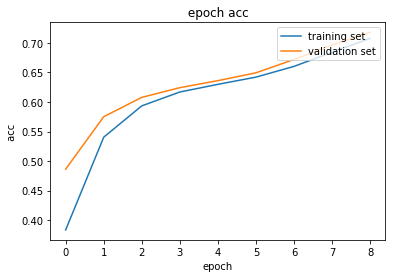

----------------- train : epoch of 9 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.10150084
train acc: 0.72203976
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.092494585
train acc: 0.7255581
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.09918419
train acc: 0.7286803
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.089801945
train acc: 0.73190624
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.075905785
train acc: 0.7334981
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.07918383
val acc: 0.7369475
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.112745196
val acc: 0.7372834
Epoch: 10 / 30  Loss: 0.076  Time:  0:00:16.785614
train Accuracy = 0.728
Validation Accuracy = 0.737
-----

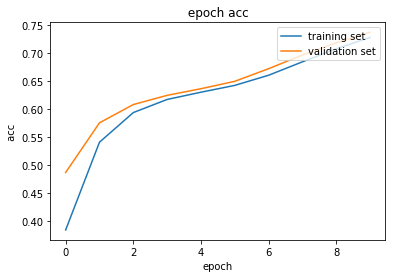

----------------- train : epoch of 10 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.07692708
train acc: 0.7407186
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.08501288
train acc: 0.743912
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.09322904
train acc: 0.7466705
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.079468854
train acc: 0.74947065
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.08709109
train acc: 0.75055474
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.065579586
val acc: 0.7535247
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.05361573
val acc: 0.75392234
Epoch: 11 / 30  Loss: 0.087  Time:  0:00:16.813869
train Accuracy = 0.746
Validation Accuracy = 0.754


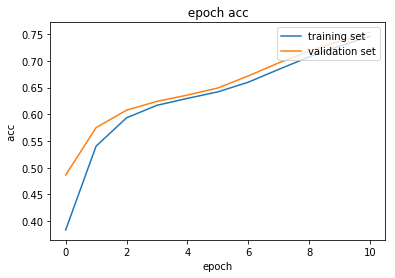

----------------- train : epoch of 11 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.061863564
train acc: 0.75690186
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.09339222
train acc: 0.7595075
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.068527736
train acc: 0.7622841
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.06812525
train acc: 0.76496875
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.061314274
train acc: 0.7661065
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.056564998
val acc: 0.768727
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.095610544
val acc: 0.768943
Epoch: 12 / 30  Loss: 0.061  Time:  0:00:16.733150
train Accuracy = 0.761
Validation Accuracy = 0.769


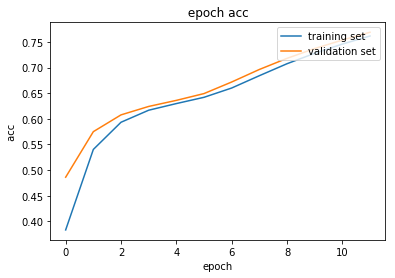

----------------- train : epoch of 12 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.0574435
train acc: 0.77148575
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.065375246
train acc: 0.77390397
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.06506608
train acc: 0.7762462
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.06476529
train acc: 0.7785245
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.04919101
train acc: 0.77962834
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.051853914
val acc: 0.78198063
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.043135203
val acc: 0.78229326
Epoch: 13 / 30  Loss: 0.049  Time:  0:00:16.607770
train Accuracy = 0.775
Validation Accuracy = 0.782


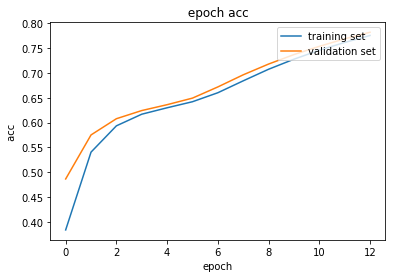

----------------- train : epoch of 13 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.058727246
train acc: 0.7845138
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.05398186
train acc: 0.7867101
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.047372635
train acc: 0.78901803
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.0608326
train acc: 0.7911033
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.055977207
train acc: 0.792022
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.04635268
val acc: 0.79412854
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.053749386
val acc: 0.7943788
Epoch: 14 / 30  Loss: 0.056  Time:  0:00:16.554866
train Accuracy = 0.788
Validation Accuracy = 0.794


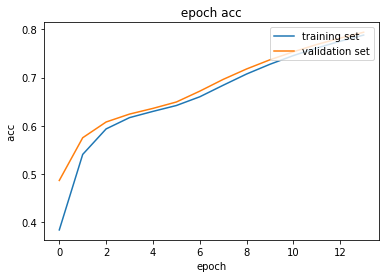

----------------- train : epoch of 14 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.053032756
train acc: 0.79637605
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.052363157
train acc: 0.79828453
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.054719213
train acc: 0.80012685
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.053212974
train acc: 0.8019591
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.038450606
train acc: 0.8028436
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.044206657
val acc: 0.80473876
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.03577169
val acc: 0.8049818
Epoch: 15 / 30  Loss: 0.038  Time:  0:00:16.540442
train Accuracy = 0.800
Validation Accuracy = 0.805


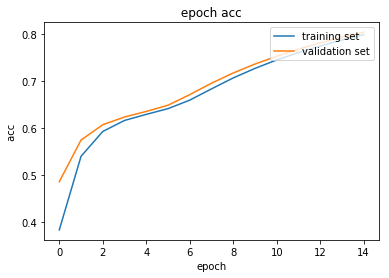

----------------- train : epoch of 15 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.040894087
train acc: 0.8068755
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.040378276
train acc: 0.8086907
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.062368523
train acc: 0.8102297
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.040107936
train acc: 0.81198823
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.05529866
train acc: 0.81269413
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.041465096
val acc: 0.814366
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.036733992
val acc: 0.81458026
Epoch: 16 / 30  Loss: 0.055  Time:  0:00:16.656727
train Accuracy = 0.810
Validation Accuracy = 0.814


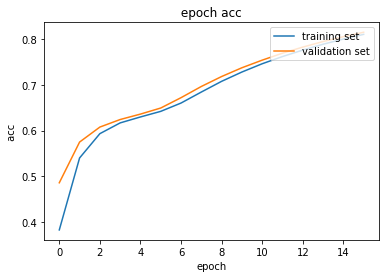

----------------- train : epoch of 16 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.042067412
train acc: 0.81623596
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.04437072
train acc: 0.81774724
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.044257235
train acc: 0.8192535
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.048652258
train acc: 0.820728
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.042812247
train acc: 0.82138914
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.039057642
val acc: 0.82290876
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.035176415
val acc: 0.82310236
Epoch: 17 / 30  Loss: 0.043  Time:  0:00:16.585246
train Accuracy = 0.819
Validation Accuracy = 0.823


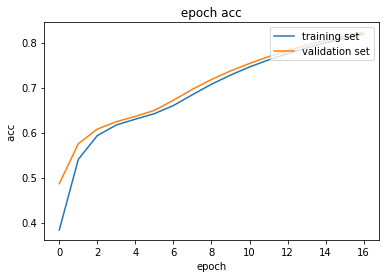

----------------- train : epoch of 17 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.04233603
train acc: 0.8245737
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.03749989
train acc: 0.82603574
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.040026
train acc: 0.8274244
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.045544278
train acc: 0.8287506
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.036441524
train acc: 0.8293649
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.038356464
val acc: 0.8307361
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.035867646
val acc: 0.8309108
Epoch: 18 / 30  Loss: 0.036  Time:  0:00:16.639767
train Accuracy = 0.827
Validation Accuracy = 0.831


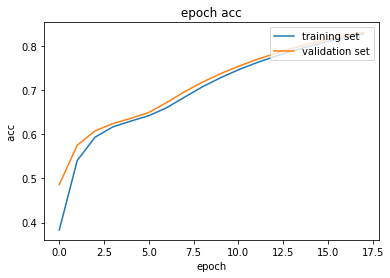

----------------- train : epoch of 18 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.05227798
train acc: 0.83212715
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.034714133
train acc: 0.8334832
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.03626121
train acc: 0.8347646
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.03699752
train acc: 0.8360283
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.031083673
train acc: 0.8366078
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03316794
val acc: 0.83788735
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.05162084
val acc: 0.8380216
Epoch: 19 / 30  Loss: 0.031  Time:  0:00:16.626945
train Accuracy = 0.834
Validation Accuracy = 0.838


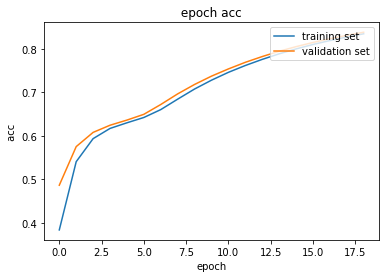

----------------- train : epoch of 19 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.03661545
train acc: 0.8392365
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.04666003
train acc: 0.8403458
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.036528874
train acc: 0.8414924
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.032930866
train acc: 0.8426812
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.026873248
train acc: 0.84321177
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.035780977
val acc: 0.84433454
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.019761905
val acc: 0.84449416
Epoch: 20 / 30  Loss: 0.027  Time:  0:00:16.635621
train Accuracy = 0.841
Validation Accuracy = 0.844
--

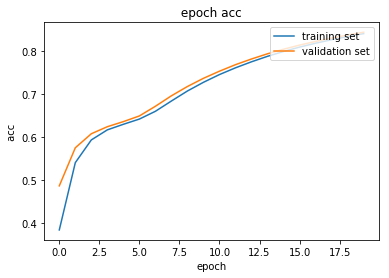

----------------- train : epoch of 20 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.03704346
train acc: 0.8456025
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.03477668
train acc: 0.8466939
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.030482544
train acc: 0.8477846
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.038362518
train acc: 0.848826
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.03618266
train acc: 0.8492677
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03267578
val acc: 0.8503142
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.026556667
val acc: 0.8504516
Epoch: 21 / 30  Loss: 0.036  Time:  0:00:16.752502
train Accuracy = 0.847
Validation Accuracy = 0.850


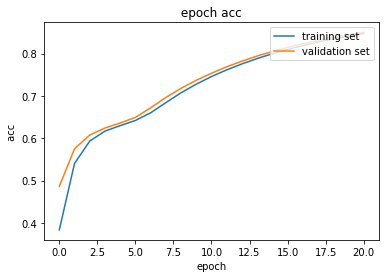

----------------- train : epoch of 21 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.031478107
train acc: 0.8515023
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.024440313
train acc: 0.8525768
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.036702387
train acc: 0.85355574
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.034808896
train acc: 0.854512
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.047262568
train acc: 0.85483724
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03082761
val acc: 0.8557999
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.051439233
val acc: 0.85589784
Epoch: 22 / 30  Loss: 0.047  Time:  0:00:16.631701
train Accuracy = 0.853
Validation Accuracy = 0.856


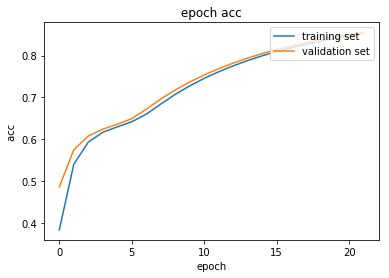

----------------- train : epoch of 22 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.033583984
train acc: 0.856824
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.037619904
train acc: 0.857703
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.030885091
train acc: 0.8585906
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.04203489
train acc: 0.85940295
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.031382076
train acc: 0.85979587
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03299945
val acc: 0.86066973
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.054659523
val acc: 0.86075705
Epoch: 23 / 30  Loss: 0.031  Time:  0:00:16.662834
train Accuracy = 0.858
Validation Accuracy = 0.861


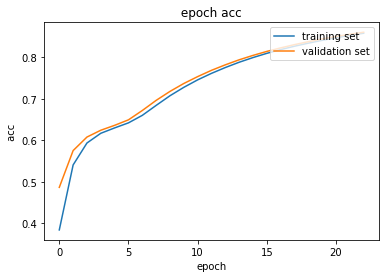

----------------- train : epoch of 23 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.034826487
train acc: 0.8616067
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.040492907
train acc: 0.862395
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.03613858
train acc: 0.86318594
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.034923226
train acc: 0.8639714
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.021551592
train acc: 0.8643636
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03173778
val acc: 0.8651769
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.033251975
val acc: 0.8652767
Epoch: 24 / 30  Loss: 0.022  Time:  0:00:16.693890
train Accuracy = 0.863
Validation Accuracy = 0.865


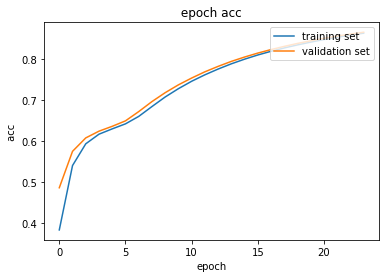

----------------- train : epoch of 24 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.02985613
train acc: 0.8661012
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.031459887
train acc: 0.86689806
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.043630235
train acc: 0.86759174
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.029111734
train acc: 0.86836606
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.03164289
train acc: 0.8686929
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.03026088
val acc: 0.8694401
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.025185827
val acc: 0.8695383
Epoch: 25 / 30  Loss: 0.032  Time:  0:00:16.667031
train Accuracy = 0.867
Validation Accuracy = 0.869
---

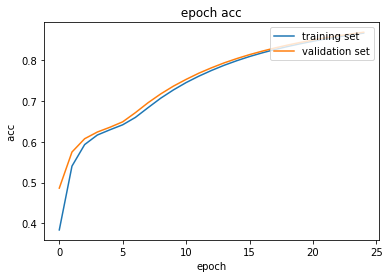

----------------- train : epoch of 25 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.027319666
train acc: 0.87029904
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.029104773
train acc: 0.87104607
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.03124733
train acc: 0.8717792
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.03211414
train acc: 0.8724937
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.045251153
train acc: 0.872732
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.030173054
val acc: 0.87342024
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.02437431
val acc: 0.87351084
Epoch: 26 / 30  Loss: 0.045  Time:  0:00:16.711908
train Accuracy = 0.872
Validation Accuracy = 0.873


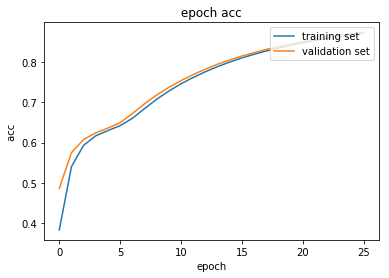

----------------- train : epoch of 26 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.025321664
train acc: 0.87421757
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.032570876
train acc: 0.87487733
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.024158778
train acc: 0.87558484
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.041365113
train acc: 0.87619287
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.03378258
train acc: 0.8764734
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.030224156
val acc: 0.8771058
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.017964702
val acc: 0.8771951
Epoch: 27 / 30  Loss: 0.034  Time:  0:00:16.617916
train Accuracy = 0.875
Validation Accuracy = 0.877


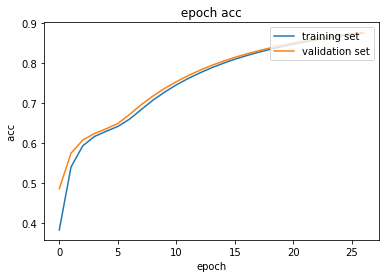

----------------- train : epoch of 27 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.03425274
train acc: 0.87779284
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.027463945
train acc: 0.8784427
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.029844737
train acc: 0.8790718
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.028184999
train acc: 0.879692
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.028215673
train acc: 0.8799664
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.030451525
val acc: 0.88057065
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.015714223
val acc: 0.88065743
Epoch: 28 / 30  Loss: 0.028  Time:  0:00:16.689209
train Accuracy = 0.879
Validation Accuracy = 0.881


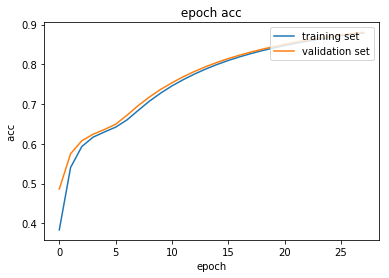

----------------- train : epoch of 28 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.03274198
train acc: 0.8812502
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.023048265
train acc: 0.8818811
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.028465444
train acc: 0.8824714
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.026462339
train acc: 0.88306034
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.041714437
train acc: 0.8832649
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.026578873
val acc: 0.8838425
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.037160557
val acc: 0.88390476
Epoch: 29 / 30  Loss: 0.042  Time:  0:00:16.622637
train Accuracy = 0.882
Validation Accuracy = 0.884


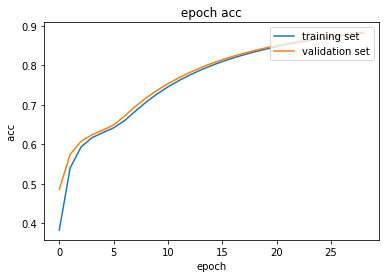

----------------- train : epoch of 29 --------------------------
-----------------batch_i = 0 , batch_size = 16 --------------------------
train loss: 0.027597567
train acc: 0.88447267
-----------------batch_i = 16 , batch_size = 16 --------------------------
train loss: 0.025033934
train acc: 0.88504946
-----------------batch_i = 32 , batch_size = 16 --------------------------
train loss: 0.025541462
train acc: 0.885617
-----------------batch_i = 48 , batch_size = 16 --------------------------
train loss: 0.027865177
train acc: 0.88616
-----------------batch_i = 64 , batch_size = 16 --------------------------
train loss: 0.05077141
train acc: 0.886329
-----------------batch_i = 0 , batch_size = 16 --------------------------
val loss: 0.029718455
val acc: 0.88684547
-----------------batch_i = 16 , batch_size = 16 --------------------------
val loss: 0.021383747
val acc: 0.8869141
Epoch: 30 / 30  Loss: 0.051  Time:  0:00:16.594368
train Accuracy = 0.885
Validation Accuracy = 0.887
-----

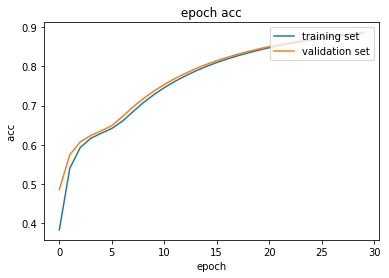

train_acc_array : [0.38354334 0.5403699  0.59334862 0.61679857 0.629757   0.64195599
 0.66007634 0.68407029 0.70740759 0.72768221 0.74572156 0.76142733
 0.77549247 0.78824897 0.79954718 0.80976629 0.81877689 0.82695923
 0.83434798 0.84116306 0.84742796 0.85321422 0.85829436 0.86294493
 0.86738258 0.87153538 0.87534191 0.87886977 0.88227413 0.8854238 ]
val_acc_array : [0.48627946 0.57502411 0.60771832 0.62415647 0.63599096 0.64924224
 0.67178399 0.69620815 0.71788476 0.7369848  0.7535689  0.76875101
 0.78201537 0.79415635 0.80476577 0.81438979 0.82293027 0.83075551
 0.83790226 0.84435228 0.85032947 0.85581079 0.86067943 0.865188
 0.86945099 0.87343031 0.8771157  0.88058029 0.88384944 0.88685309]


In [28]:
EPOCHS = 30 #1 #50 #1 #10 #1

run()

In [20]:
test= []
test.append(0.10815138)
a = 0.10815138
print(type(a))

<class 'float'>


In [21]:
b= np.float64(0.10815138)
print(type(b))

<class 'numpy.float64'>


In [22]:
test.append(b)
print(test)

[0.10815138, 0.10815138]


In [24]:
val = list()
val.append(b)
print(val)

[0.10815138]


In [ ]:
"""
sess=tf.Session() 
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('./models_lyft/cont_epoch_0.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./models_lyft'))
tvs = [v for v in tf.trainable_variables()]
for v in tvs:
    print(v.name)
    #print(sess.run(v))
    
"""

In [18]:
def evaluate(logits, X_data, y_data, input_image, correct_label):
    num_examples = len(X_data)
    total_accuracy = 0
        
    sess = tf.get_default_session()
    
    #####  print out validation accuracy with train loss :
    #y = tf.placeholder(tf.int64, (None, None, None)) ## 256, 512, 3?
    #one_hot_y = tf.one_hot(y, 3)

    #logits  = correct_label?
        
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    #accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #####  print out validation accuracy with train loss :
    
    get_batches_fn = gen_batch_function( X_data, y_data ,  IMAGE_SHAPE)
    #batch_x_arr, batch_y_arr = get_batches_fn( BATCH_SIZE)
    #print(" batch len  x:" , len(batch_x_arr), " batch len  y:" , len(batch_y_arr))
    
    for image, targets in get_batches_fn( BATCH_SIZE):
                                         
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(targets, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))                                 
        accuracy = sess.run(accuracy_operation, feed_dict = {input_image: image, 
                                                             correct_label: targets })
        
        print( "accuracy" , accuracy)
    '''
        #for offset in range(0, num_examples, BATCH_SIZE):
    for image, targets in get_batches_fn( X_data, y_data , BATCH_SIZE):
        #batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        accuracy = sess.run(accuracy_operation, feed_dict = {input_image: image, 
                                                             correct_label: targets })
        
        #im_softmax = sess.run([tf.nn.softmax(logits)],{keep_prob: 1.0, image_pl: [image]}) 
    
        # Road
        #im_softmax_r = im_softmax[0][:, 0].reshape(image_shape[0], image_shape[1])
        #segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
        
    
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples
    '''


In [ ]:
sess=tf.Session() 
new_saver = tf.train.Saver()
#saver.restore(sess, model_path)

#tvs = [v for v in tf.trainable_variables()]
#for v in tvs:
#    print(v.name)
    
                
new_saver = tf.train.import_meta_graph('./models_lyft/epoch_0.ckpt.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./models_lyft/'))   





In [ ]:
logits = tf.get_collection("logits")
print(logits)

In [17]:
def train_nn_eval(sess, epochs, batch_size, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, saver, data_dir, logits):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function

    if summaries_dir is not None:
        summary_writer = tf.summary.FileWriter(summaries_dir, graph=sess.graph)
            
    
    for epoch in range(epochs):
        print("----------------- train : epoch of " + str(epoch) + " --------------------------")
        
        #if validation_accuracy > 0.95:
        #    break
        s_time = time.time()
        
        get_batches_fn =  gen_batch_function( X_train, y_train, IMAGE_SHAPE)
        for image, targets in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict = {input_image: image, 
                                                                            correct_label: targets, 
                                                                            keep_prob: KEEP_PROB, 
                                                                            learning_rate: LEARNING_RATE }) #/ (epoch/100 + 1)
            print(loss)
        
        validation_accuracy = evaluate(logits, X_valid, y_validation, input_image, correct_label )
                
        # Print data on the learning process
        print("Epoch: {}".format(epoch + 1), "/ {}".format(epochs), " Loss: {:.3f}".format(loss), " Time: ",
              str(timedelta(seconds=(time.time() - s_time))))
        
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        
        #if (epoch + 1) % 10 == 0: # Save every 10 epochs
        #    save_path = saver.save(sess, os.path.join(data_dir, 'cont_epoch_' + str(epoch) + '.ckpt'))
        
        #print("-----------------save ckpt after every epoch --------------------------")
        #save_path = saver.save(sess, os.path.join(data_dir, 'cont_epoch_' + str(epoch) + '.ckpt'))

In [ ]:
graph = tf.get_default_graph()

[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
"""
# import the inspect_checkpoint library
from tensorflow.python.tools import inspect_checkpoint as chkp

# print only tensor v1 in checkpoint file
chkp.print_tensors_in_checkpoint_file("./models_lyft/cont_epoch_0.ckpt.meta", tensor_name='logits', all_tensors=False,all_tensor_names=False)
"""


In [ ]:
output_node = graph.get_tensor_by_name("layer7_out:0")

In [ ]:
print(output_node)

In [ ]:
input = graph.get_tensor_by_name('image_input:0')

In [ ]:
image_shape = IMAGE_SHAPE

print('Training Finished. Saving test images to: {}'.format(output_dir))

In [ ]:
keep_prob = graph.get_tensor_by_name('keep_prob:0')

In [ ]:
logits = tf.reshape(output_node, (-1, NUM_CLASSES))

In [ ]:
for image_file in os.listdir(val_dataset_dir):
    image = scipy.misc.imresize(scipy.misc.imread(os.path.join(val_dataset_dir, image_file)), image_shape)
    street_im = scipy.misc.toimage(image)
        
    im_softmax = sess.run([tf.nn.softmax(logits)],{keep_prob: 1.0, input: [image]}) 
    
    # Road
    im_softmax_r = im_softmax[0][:, 0].reshape(image_shape[0], image_shape[1])
    segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation_r, np.array([[128, 64, 128, 64]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im.paste(mask, box=None, mask=mask)
        
    # Car
    im_softmax_r = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation_r, np.array([[0, 0, 142, 64]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im.paste(mask, box=None, mask=mask)
    
    scipy.misc.imsave(os.path.join(output_dir, image_file), street_im)

In [ ]:
pred =  [None]
pred_node_names = [None]
pred_node_names[0] = 'output_'+str(0)

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

In [ ]:

predpred  ==  [None]
pred_node_namespred_nod  = [None]
pred_node_names[0] = 'output_'+str(0)
pred[0] = tf.identity(model.output[0], name=pred_node_names[0])

sess = K.get_session()
tf.Session()    
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, 'model', 'model_classification.pb', as_text=False)
print('Keras model converted to TensorFlow model!')

print(pred_node_names)

In [ ]:
graph = tf.get_default_graph()

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
print(graph.get_operations())

In [ ]:

# get tensor by name, the name is named when define the network
#x = graph.get_tensor_by_name('image_input:0')    # input image
#y_ = graph.get_tensor_by_name('input_y_:0')  # input label
output = graph.get_tensor_by_name('fc/output:0')  # output result from deepNN (predict label)
#keep_prob_ = graph.get_tensor_by_name('dropout/keep_prob:0')  # keep probability


In [ ]:

input = graph.get_tensor_by_name('image_input:0')

In [ ]:
#output = graph.get_tensor_by_name('output')
#output = graph.get_tensor_by_name('output_0:0')
output_node = graph.get_tensor_by_name("output_node:0")

In [ ]:
image_shape = IMAGE_SHAPE

print('Training Finished. Saving test images to: {}'.format(output_dir))

In [ ]:


for image_file in os.listdir(val_dataset_dir):
    image = scipy.misc.imresize(scipy.misc.imread(os.path.join(val_dataset_dir, image_file)), image_shape)
    street_im = scipy.misc.toimage(image)
        
    im_softmax = sess.run([tf.nn.softmax(logits)],{keep_prob: 1.0, image_pl: [image]}) 
    
    # Road
    im_softmax_r = im_softmax[0][:, 0].reshape(image_shape[0], image_shape[1])
    segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation_r, np.array([[128, 64, 128, 64]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im.paste(mask, box=None, mask=mask)
        
    # Car
    im_softmax_r = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation_r, np.array([[0, 0, 142, 64]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im.paste(mask, box=None, mask=mask)

In [ ]:
for name, image in image_outputs:
    scipy.misc.imsave(os.path.join(output_dir, name), image)

In [ ]:
logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, NUM_CLASSES)

In [ ]:
"""

test inference:  mask results onto test images

"""
#helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, input, NUM_CLASSES)



def gen_test_output(sess, logits, keep_prob, image_pl, data_folder, image_shape, num_classes):
    
    for image_file in os.listdir(val_dataset_dir):
        image = scipy.misc.imresize(scipy.misc.imread(os.path.join(val_dataset_dir, image_file)), image_shape)
        street_im = scipy.misc.toimage(image)
        
        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_pl: [image]})
        
        # im_softmax  : 'list' object has no attribute 'shape'
        #print("len :" , len(im_softmax)) # 1
        #print( "shape image :" , im_softmax[0].shape)  # (131072, 3)   = 256 x 512

        
        # Road
        im_softmax_r = im_softmax[0][:, 0].reshape(image_shape[0], image_shape[1])
        segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
        
        mask = np.dot(segmentation_r, np.array([[128, 64, 128, 64]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im.paste(mask, box=None, mask=mask)
        
        # Car
        im_softmax_r = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
        
        mask = np.dot(segmentation_r, np.array([[0, 0, 142, 64]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im.paste(mask, box=None, mask=mask)
        # Signs
        #im_softmax_r = im_softmax[0][:, 3].reshape(image_shape[0], image_shape[1])
        #segmentation_r = (im_softmax_r > 0.5).reshape(image_shape[0], image_shape[1], 1)
        #mask += np.dot(segmentation_r, np.array([[220, 220, 0, 127]]))
        
        yield os.path.basename(image_file), np.array(street_im)
        
        
def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image, num_classes):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(val_dataset_dir), image_shape, num_classes)
    
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)

In [ ]:
def inference():
    print("masking inferenced test images ...")
    
    # ========== issue here !!
    config = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
    
    with tf.Session(config=config) as sess:
        vgg_path = os.path.join(DATA_DIR, 'vgg')
        input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        output = layers(layer3, layer4, layer7, NUM_CLASSES)
        
        logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, NUM_CLASSES)
        
        save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, input, NUM_CLASSES)

In [ ]:
inference()

In [ ]:

def save_samples():
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(DATA_DIR, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(DATA_DIR, 'data_road/training'), IMAGE_SHAPE)
        input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        output = layers(layer3, layer4, layer7, NUM_CLASSES)
        correct_label = tf.placeholder(dtype = tf.float32, shape = (None, None, None, NUM_CLASSES))
        learning_rate = tf.placeholder(dtype = tf.float32)
        
        logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, NUM_CLASSES)
        sess.run(tf.global_variables_initializer())
        
        new_saver = tf.train.import_meta_graph('./models_3col/epoch_199.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./models_3col/'))
        
        # Save inference data using helper.save_inference_samples
        helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, input, NUM_CLASSES)
        
save_samples()


In [ ]:
def cont():
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(DATA_DIR, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(DATA_DIR, 'data_road/training'), IMAGE_SHAPE)
        input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        output = layers(layer3, layer4, layer7, NUM_CLASSES)
        correct_label = tf.placeholder(dtype = tf.float32, shape = (None, None, None, NUM_CLASSES))
        learning_rate = tf.placeholder(dtype = tf.float32)
        logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, NUM_CLASSES)
        sess.run(tf.global_variables_initializer())
        new_saver = tf.train.import_meta_graph('./models_3col/epoch_199.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./models_3col/'))
        saver = tf.train.Saver() #Simple model saver
        train_nn(sess, 10, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss, input, correct_label,
                 keep_prob, learning_rate,  saver, MODEL_DIR)
        helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, input, NUM_CLASSES)

In [ ]:
cont()